In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

cwd = os.getcwd().split('/')
local_repo_path = '/'.join(cwd[:-1])
raw_data_path = local_repo_path + r"/data/raw"
processed_data_path = local_repo_path + r"/data/processed"

In [2]:
train = pd.read_csv(processed_data_path + r'/train_dataset.csv', index_col = 0)
test = pd.read_csv(raw_data_path + r'/dengue_features_test.csv', index_col = None)
combined = pd.read_csv(processed_data_path + r'/combined_train_test_dataset.csv', index_col = 0)

In [ ]:
cm = sns.light_palette('green', as_cmap=True)
train.style.background_gradient(cmap=cm)

In [ ]:
cm = sns.light_palette('orange', as_cmap=True)
test.style.background_gradient(cmap=cm)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [6]:
#Checking Null Values
null_counts = pd.DataFrame([(len(train) - train.count())/len(train), (len(test) - test.count())/len(test)]).transpose().reset_index()
null_counts.rename({'index': 'Column', 0: 'Train', 1: 'Test'}, axis = 1, inplace = True)
null_counts = pd.melt(null_counts, id_vars = ['Column'], value_vars = ['Train', 'Test']).rename({'variable':'Dataset'}, axis = 1)

Text(0.5, 0, 'Proportion of Nulls')

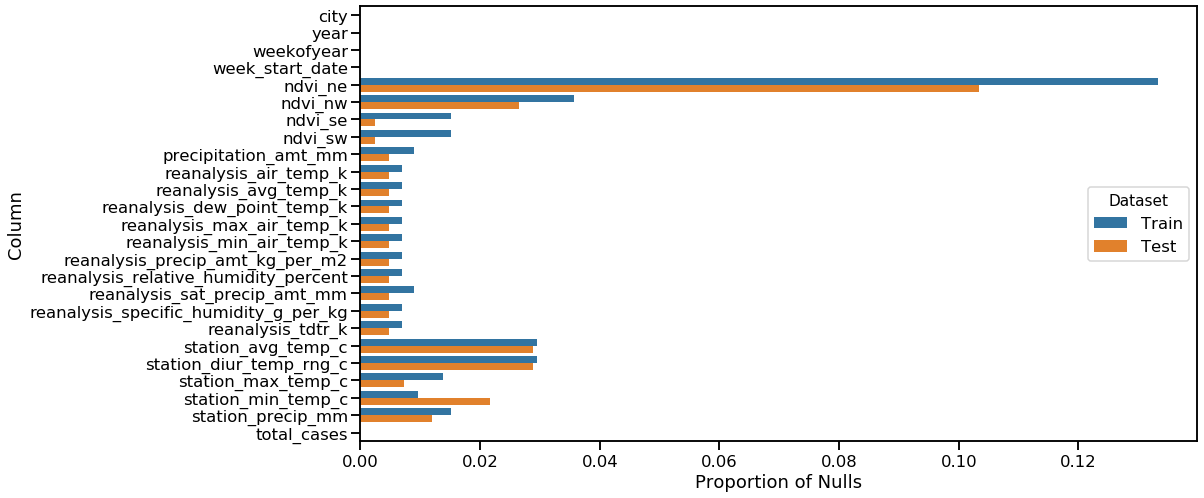

In [7]:
fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = 'value', y = 'Column', hue = 'Dataset', data = null_counts, orient = 'h', ax = ax)
plt.xlabel('Proportion of Nulls')

In [14]:
numeric_cols = combined.select_dtypes(include=[np.number]).drop(['year', 'weekofyear'], axis = 1).columns

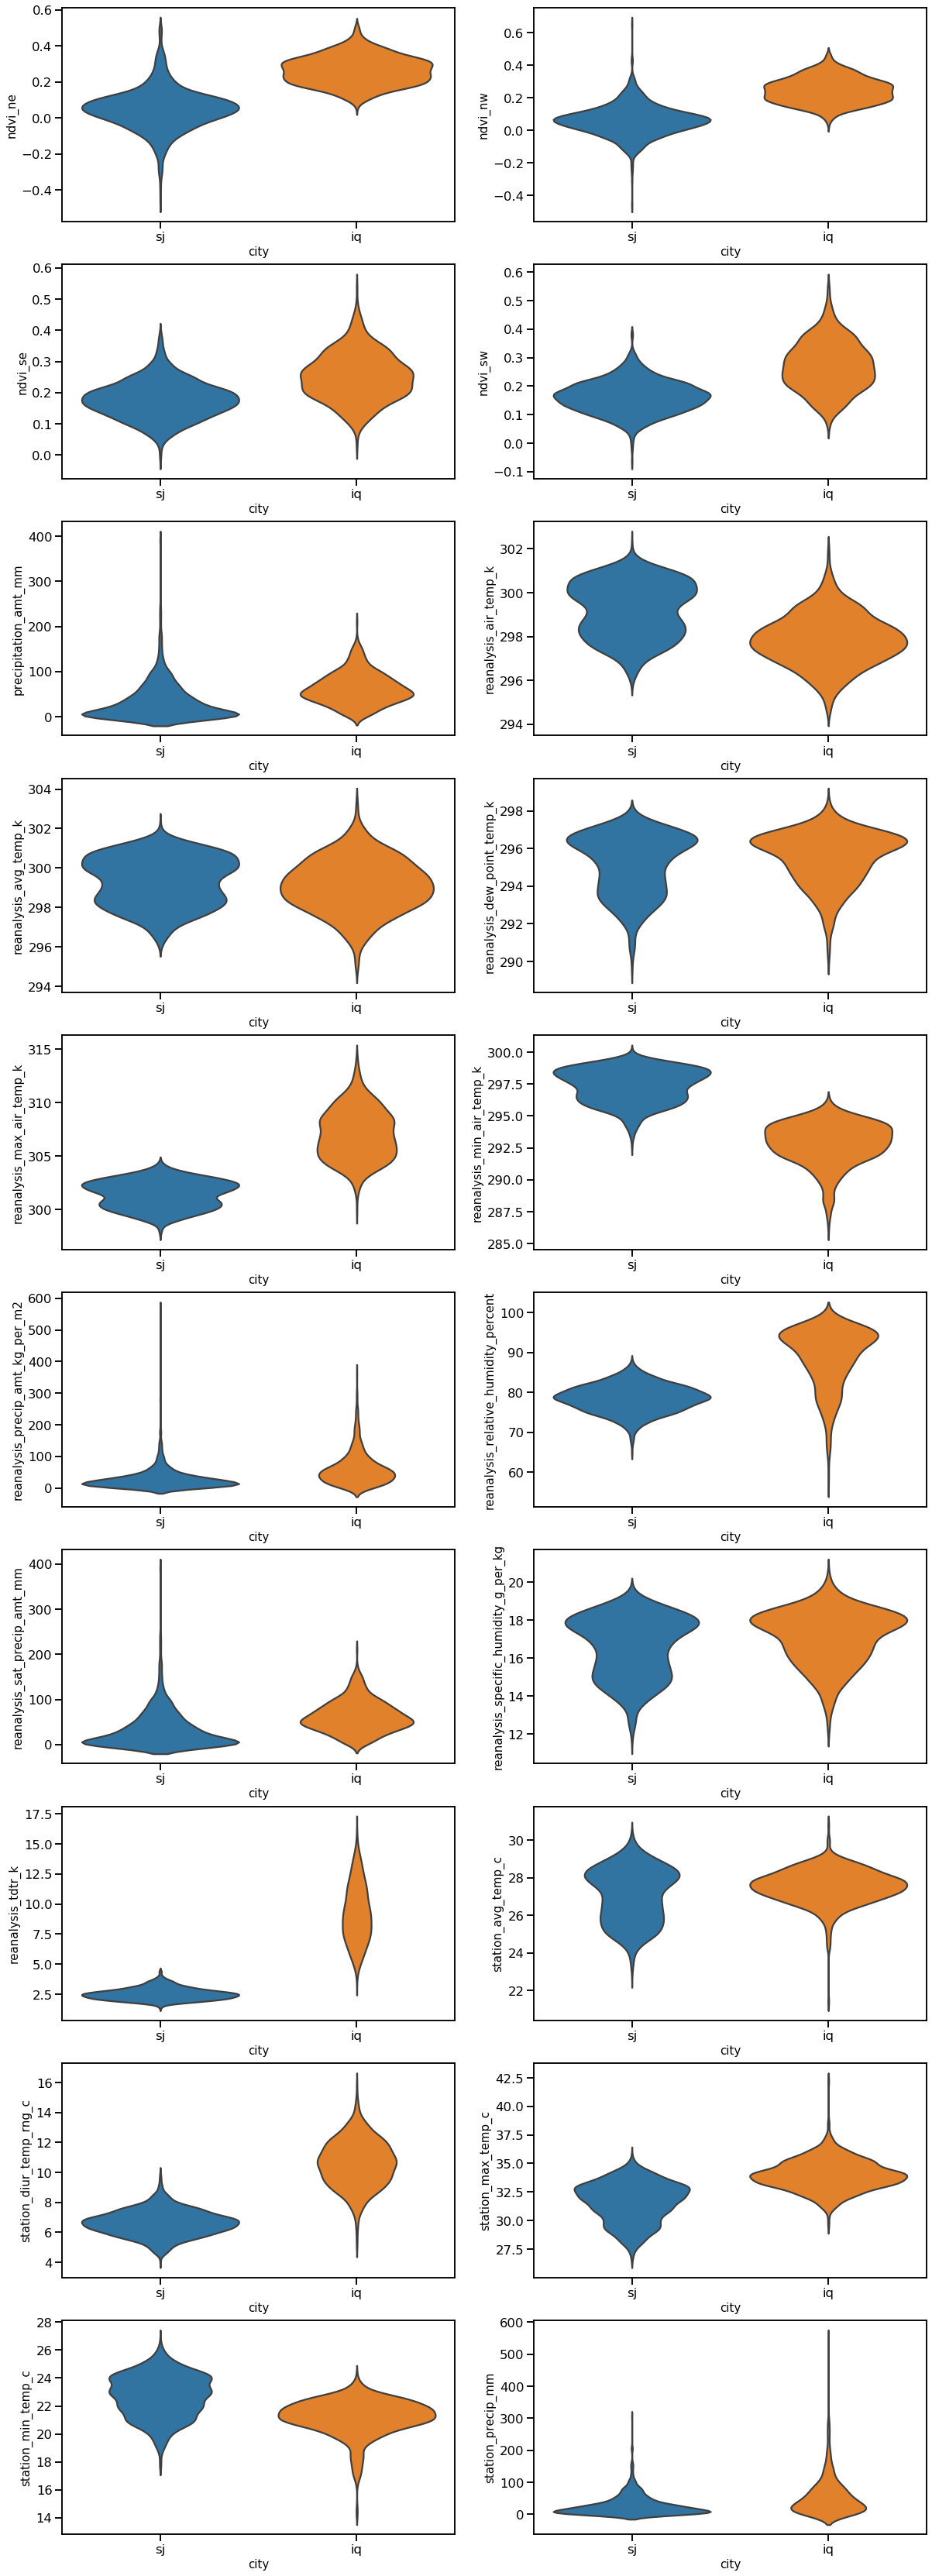

In [10]:
#Comparing all datas between cities
fix, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (20,60))
for i, j in enumerate(numeric_cols):
    sns.violinplot(x = 'city', y = j, data = combined, inner = None, ax = ax[int(np.floor(i/2)), np.mod(i,2)])
    ax[int(np.floor(i/2)),np.mod(i,2)].yaxis.label.set_size(15)
    ax[int(np.floor(i/2)),np.mod(i,2)].xaxis.label.set_size(15)

iq training date range:  2000-07-01 to 2010-06-25
sj training date range:  1990-04-30 to 2008-04-22


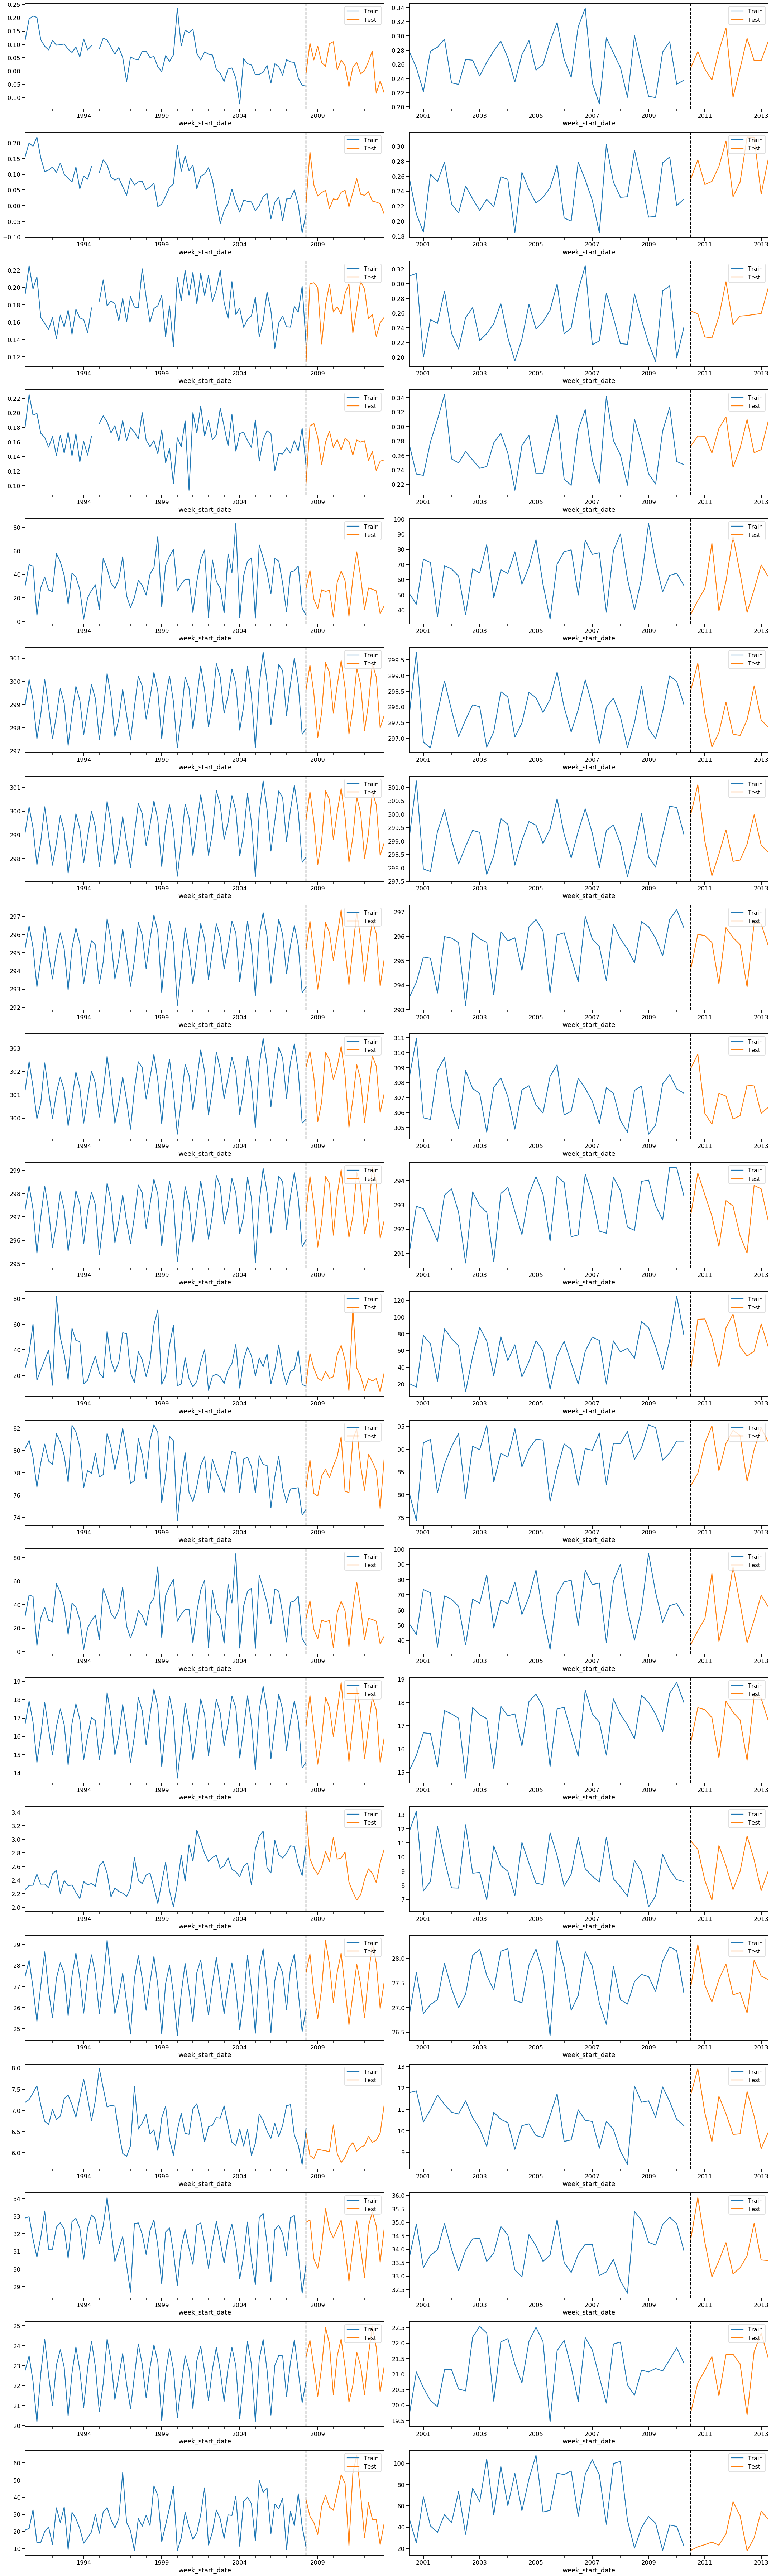

In [17]:
# Feature change over time
iq_start, iq_end = train[train['city'] == 'iq']['week_start_date'].min(), train[train['city'] == 'iq']['week_start_date'].max()
sj_start, sj_end = train[train['city'] == 'sj']['week_start_date'].min(), train[train['city'] == 'sj']['week_start_date'].max()
print('iq training date range: ', iq_start + ' to ' + iq_end)
print('sj training date range: ', sj_start + ' to ' + sj_end)

fig, ax = plt.subplots(nrows = 20, ncols = 2, figsize = (30,100))
cities = ['sj', 'iq']
for i, col in enumerate(numeric_cols):
    for j, city in enumerate(cities):
        axes = ax[i,j]
        train_test_split_date = np.where(city == 'iq', pd.Timestamp('2010-08-15'), pd.Timestamp('2008-06-30')).tolist()
        train[train['city'] == city][['week_start_date', col]].set_index(pd.DatetimeIndex(train[train['city'] == city]['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = axes)
        test[test['city'] == city][['week_start_date', col]].set_index(pd.DatetimeIndex(test[test['city'] == city]['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = axes)
        axes.axvline(train_test_split_date, color = 'black', linestyle = 'dashed')
        axes.legend(labels=['Train', 'Test'], loc = 'upper right')
        plt.tight_layout()

In [18]:
# Total cases analysis
train[train['city'] == 'iq']['total_cases'].describe()

count    520.000000
mean       7.565385
std       10.765478
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max      116.000000
Name: total_cases, dtype: float64

In [19]:
train[train['city'] == 'sj']['total_cases'].describe()

count    936.000000
mean      34.180556
std       51.381372
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64

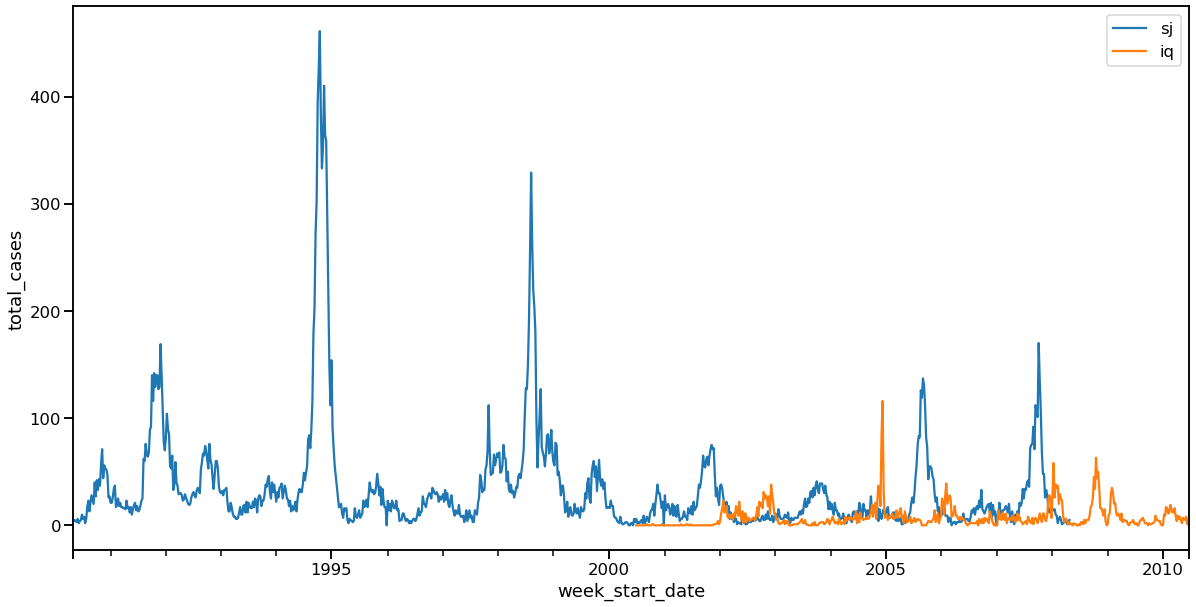

In [21]:
# Weekly total cases analysis
fig, ax = plt.subplots(figsize = (20, 10))
train[train['city'] == 'sj'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='W')).sum().plot(ax = ax)
train[train['city'] == 'iq'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'iq']['week_start_date'])).groupby(pd.Grouper(freq='W')).sum().plot(ax = ax)
ax.set_ylabel('total_cases')
ax.legend(labels = ['sj', 'iq'])

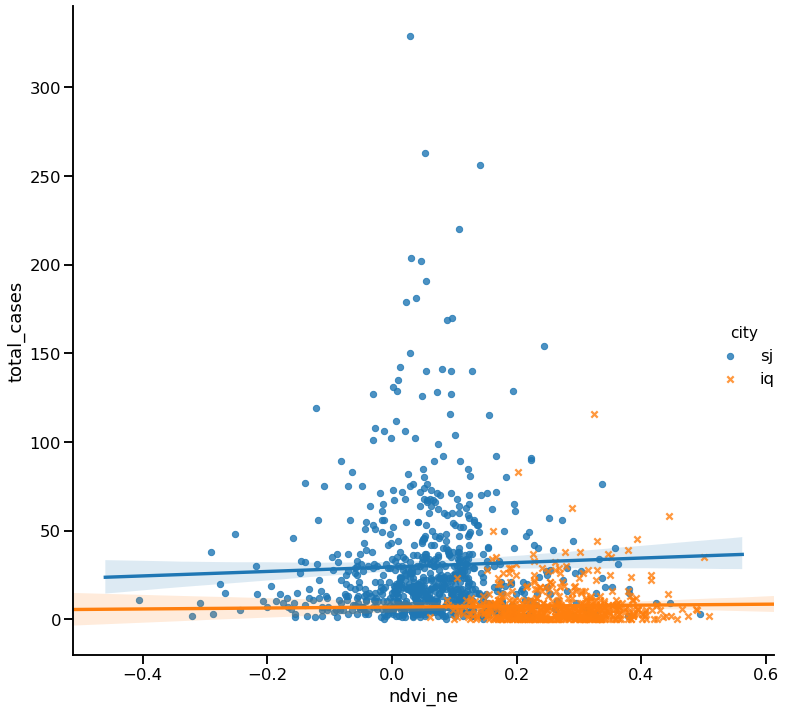

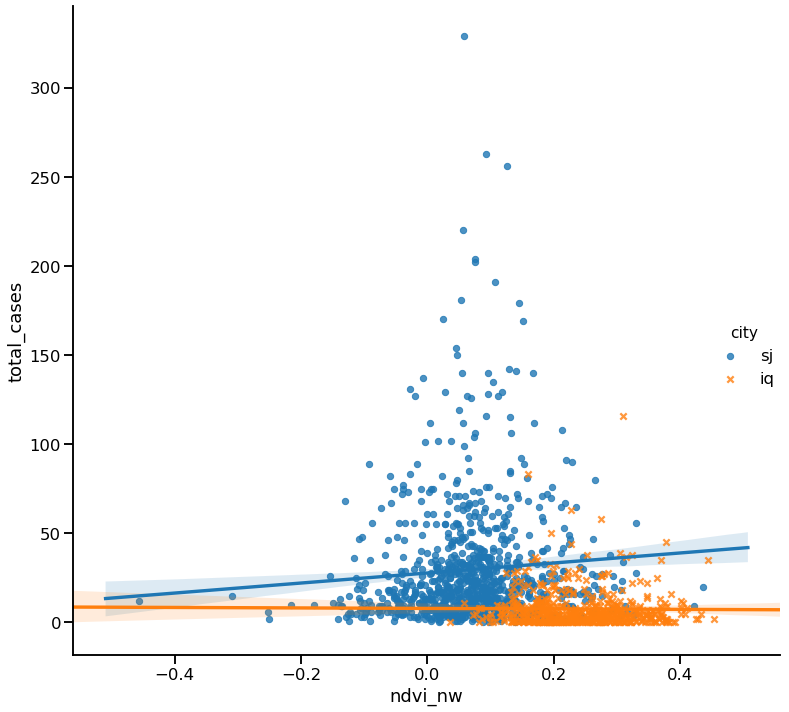

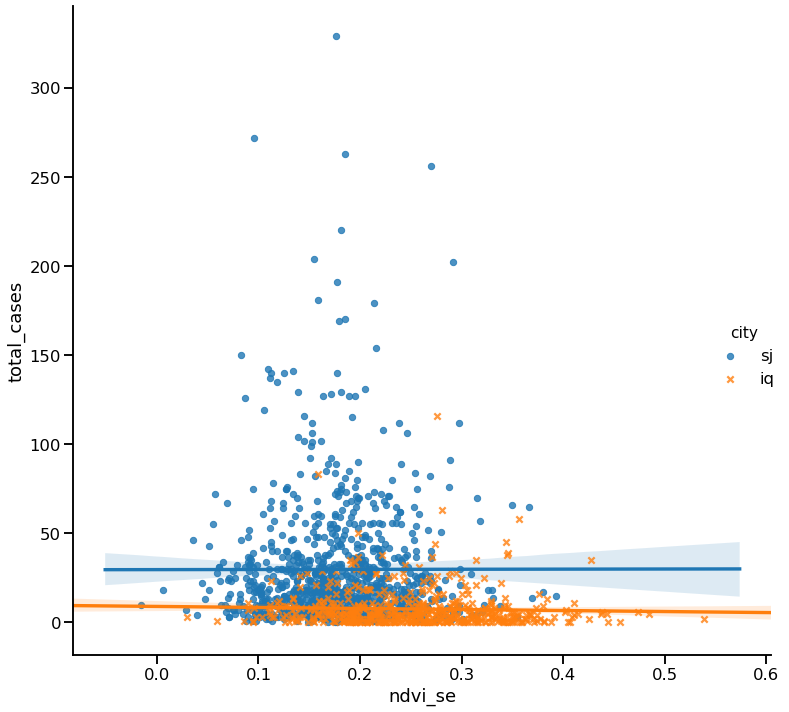

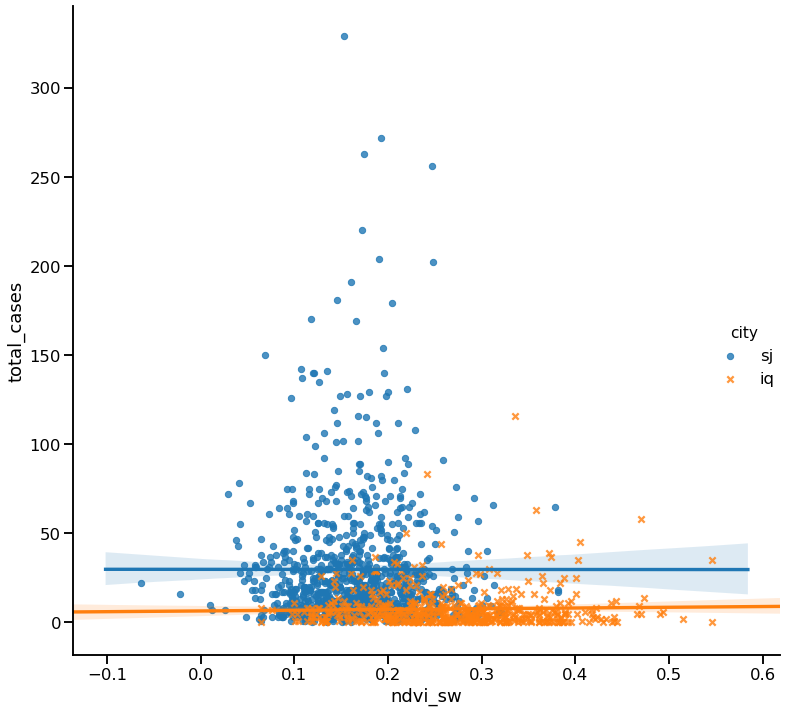

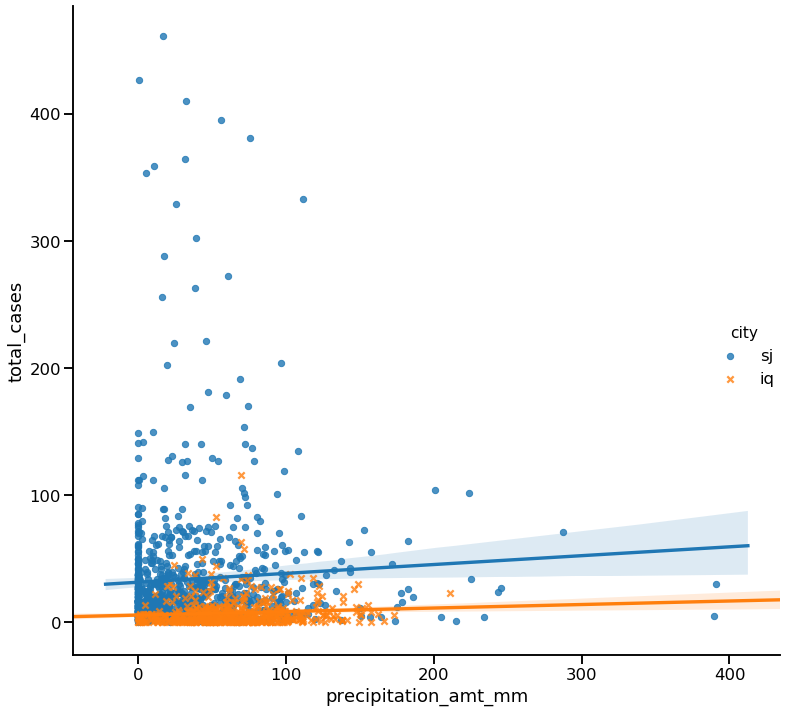

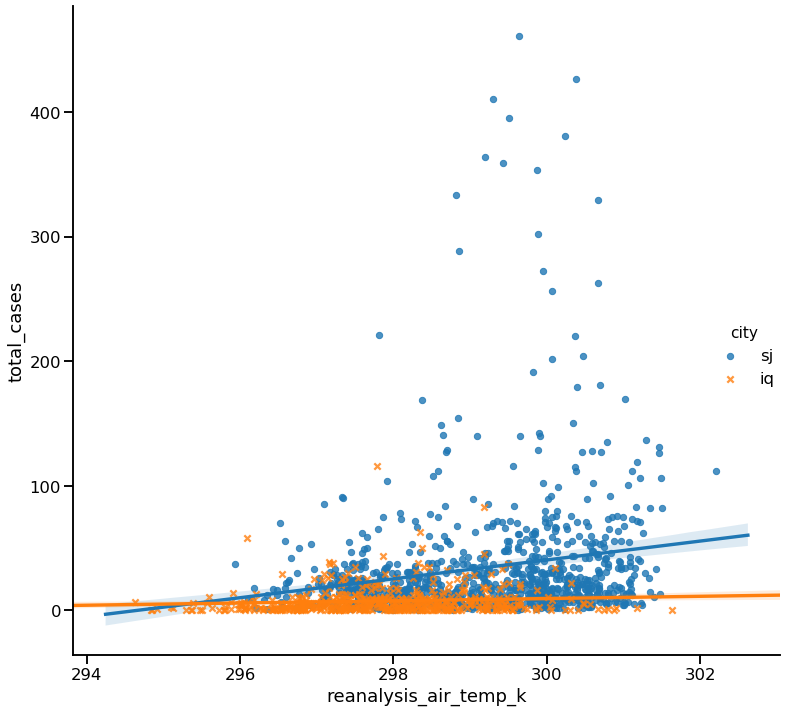

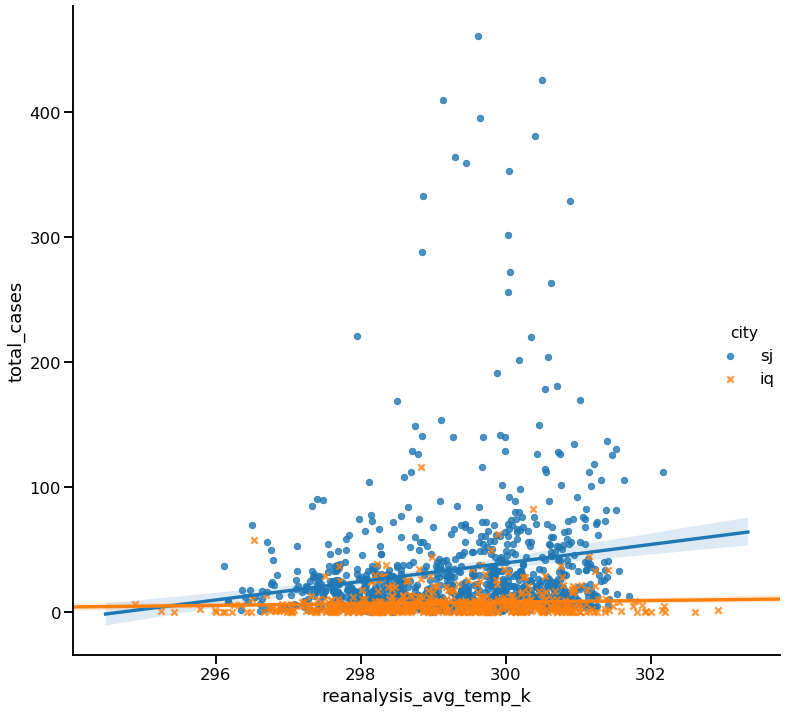

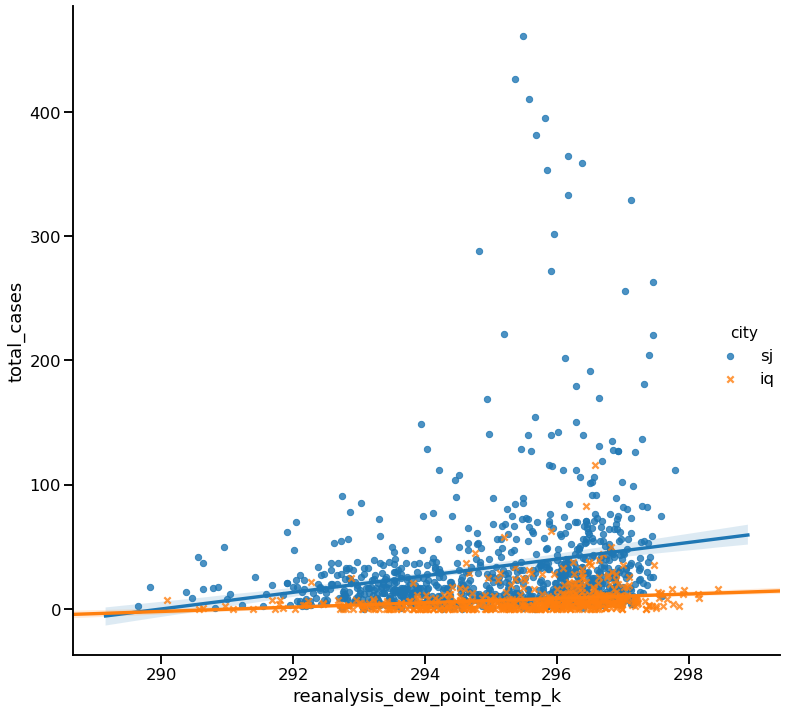

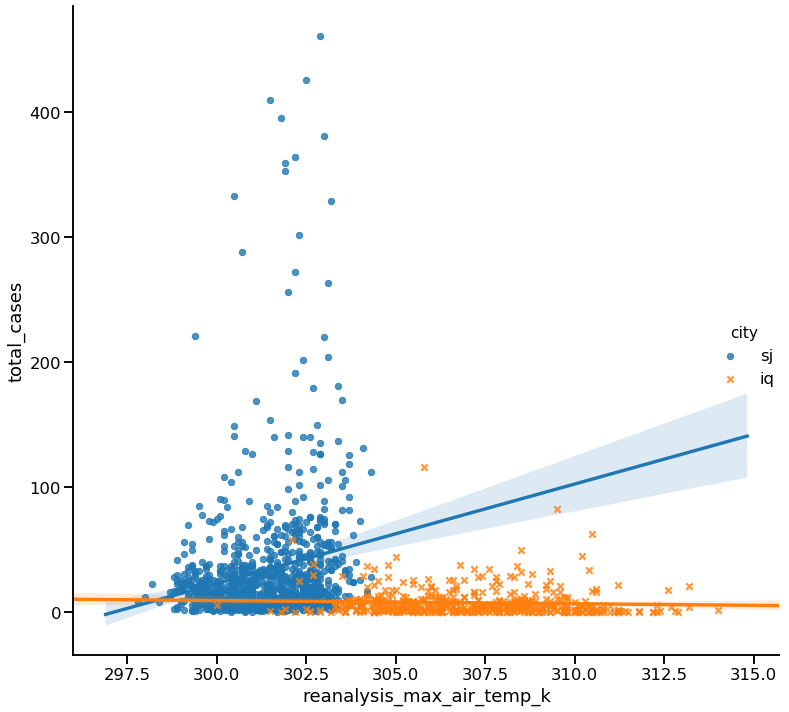

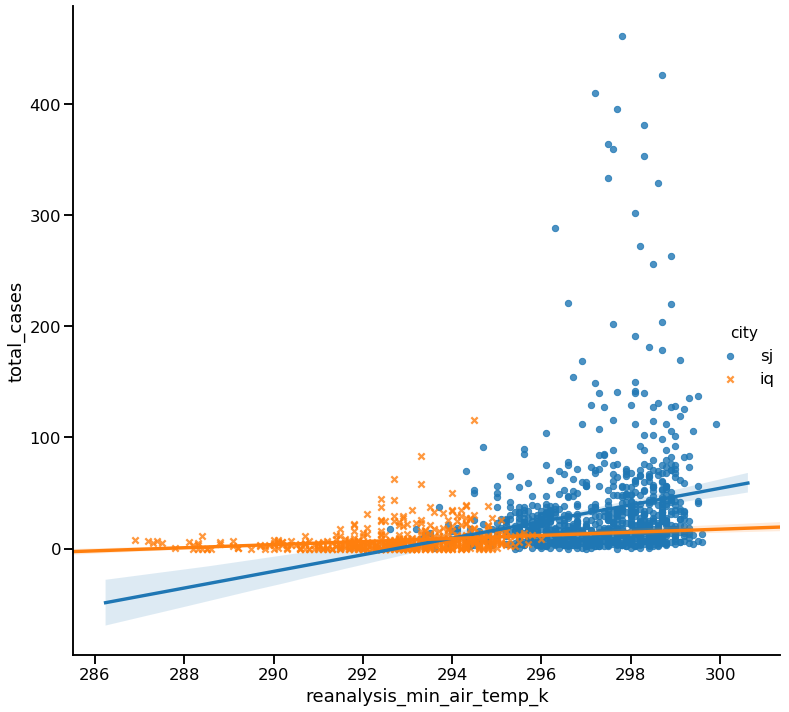

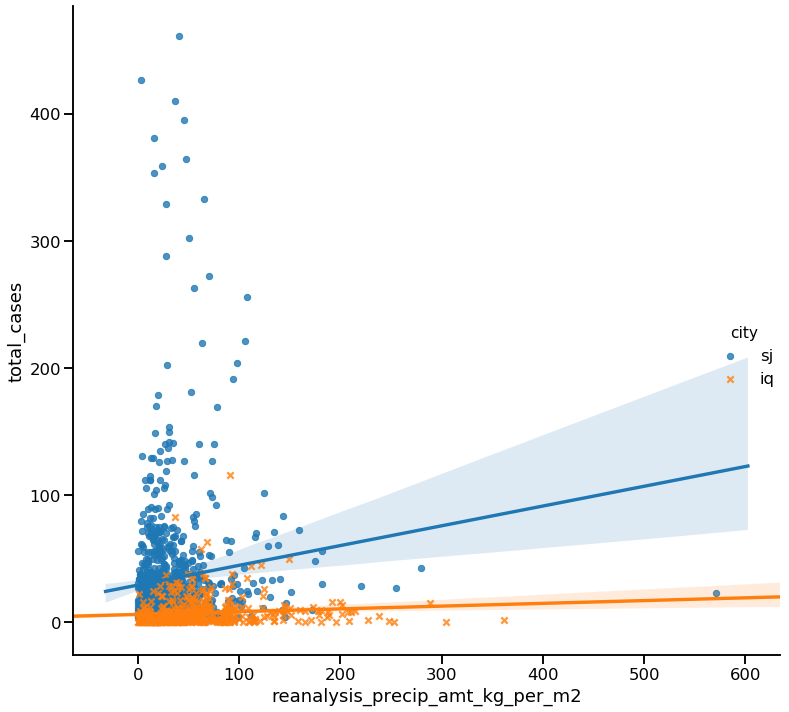

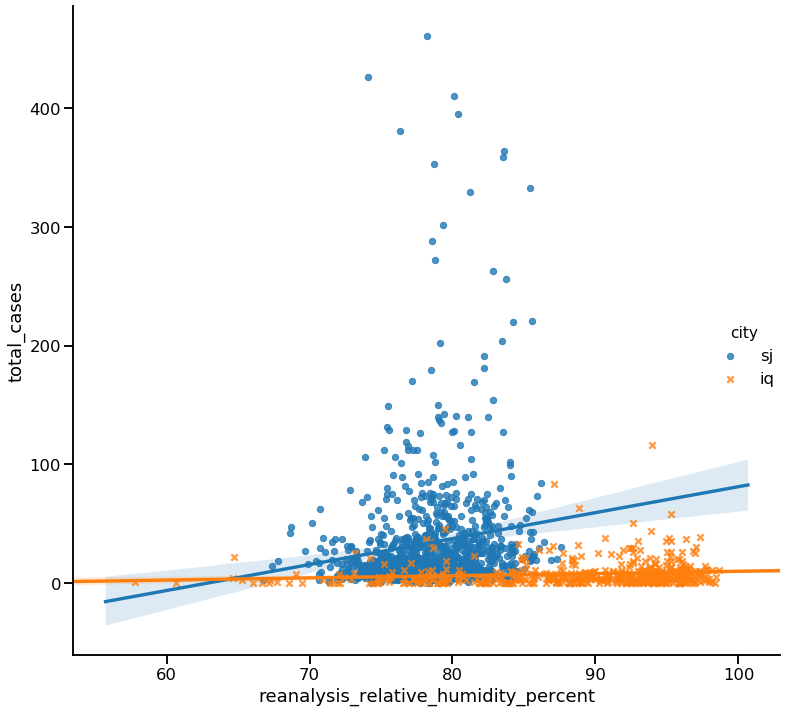

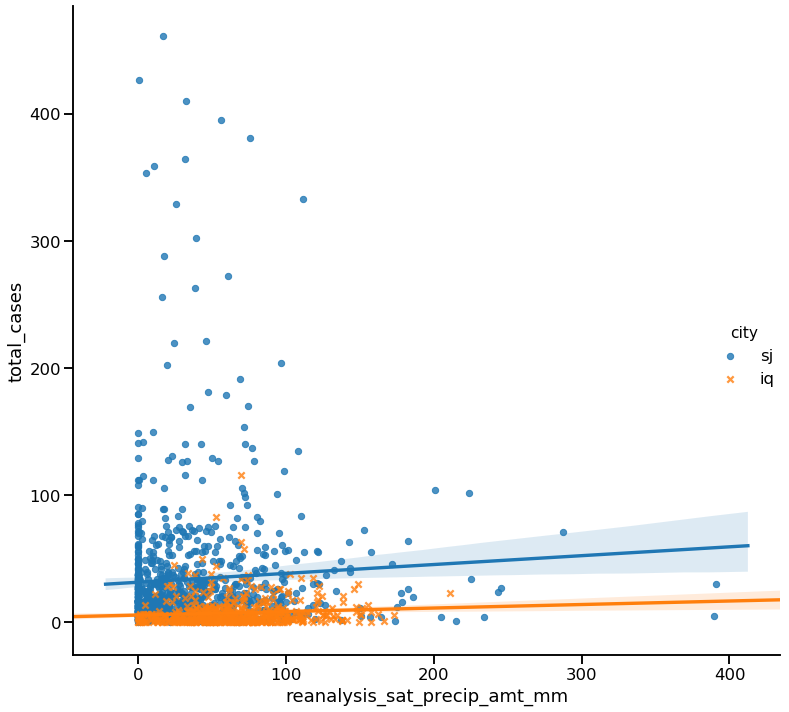

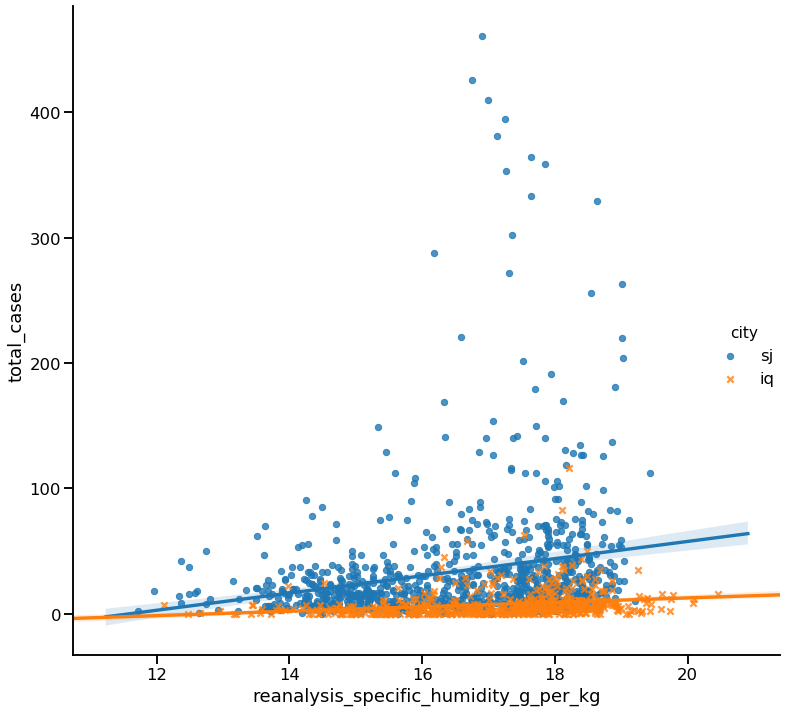

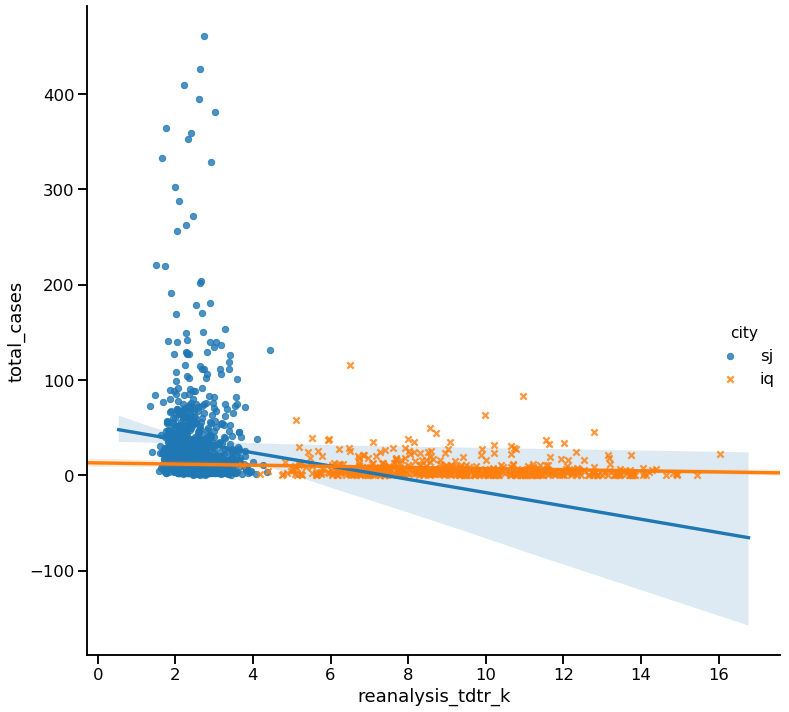

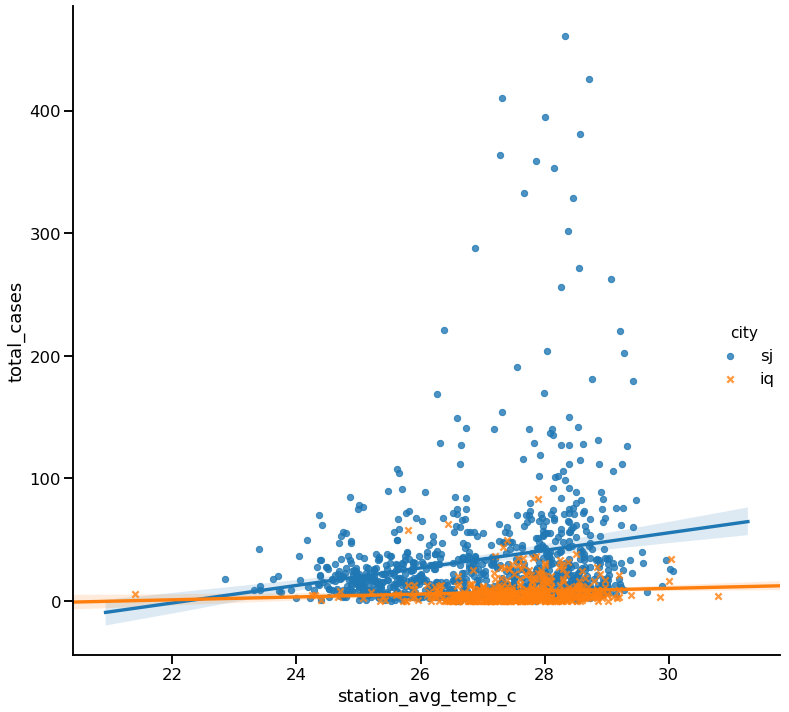

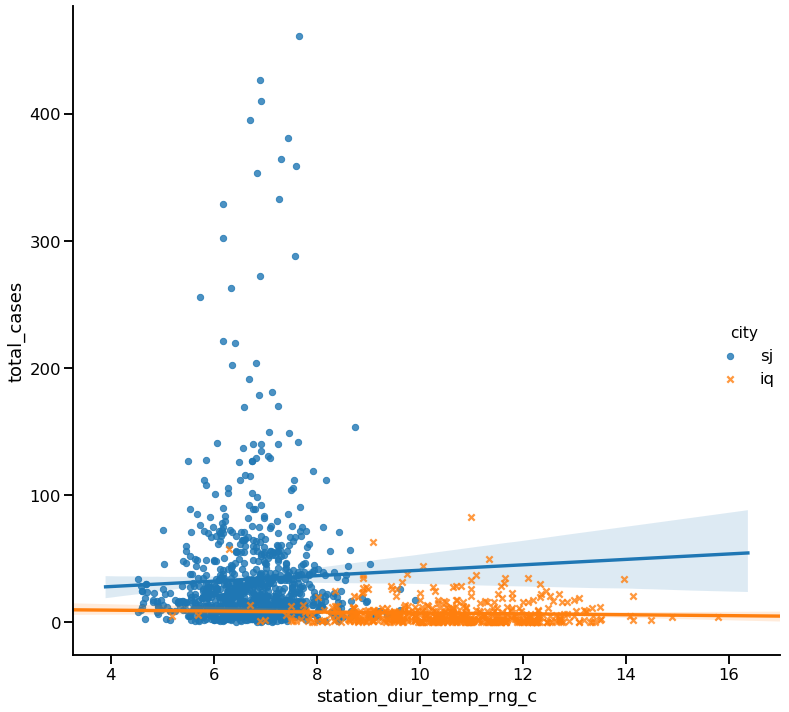

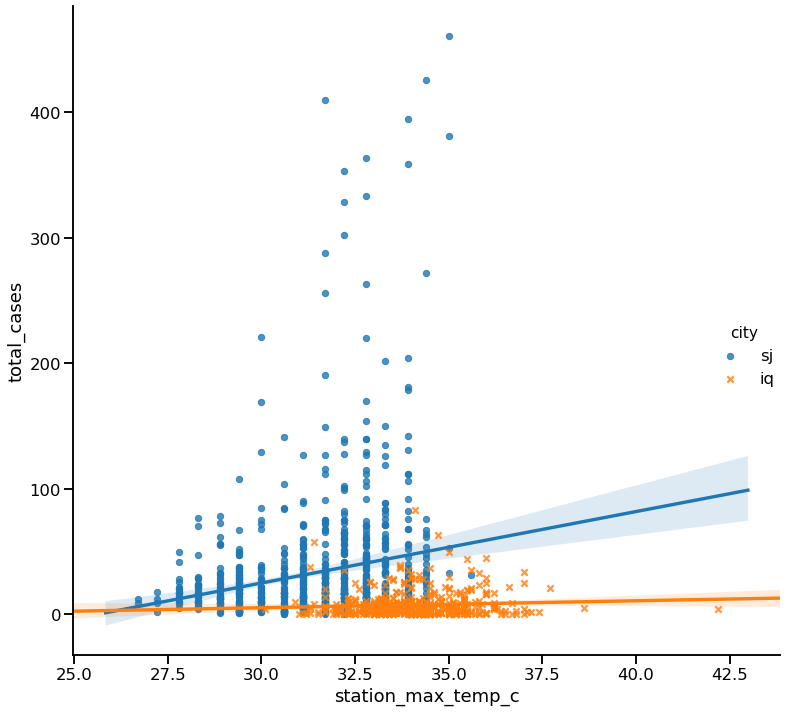

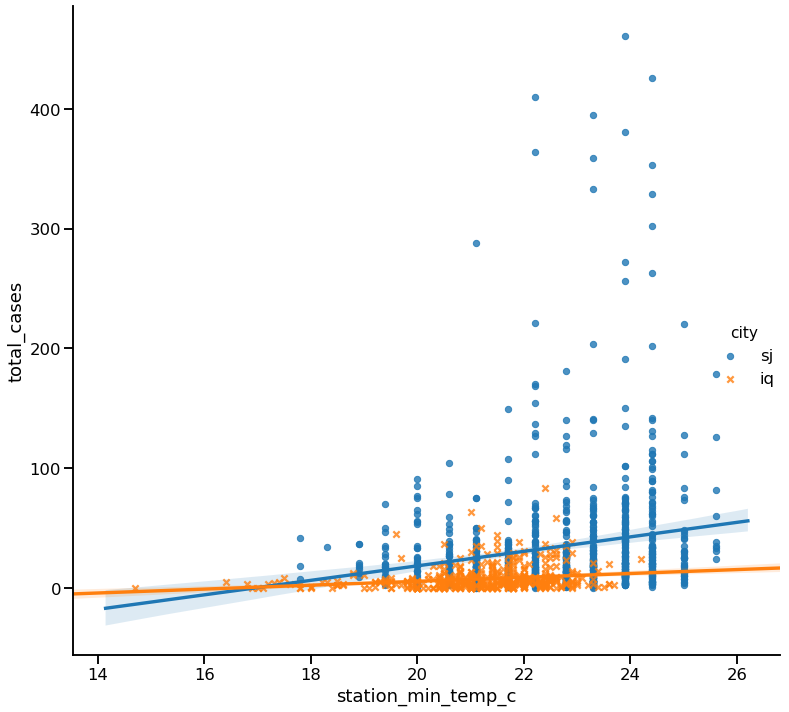

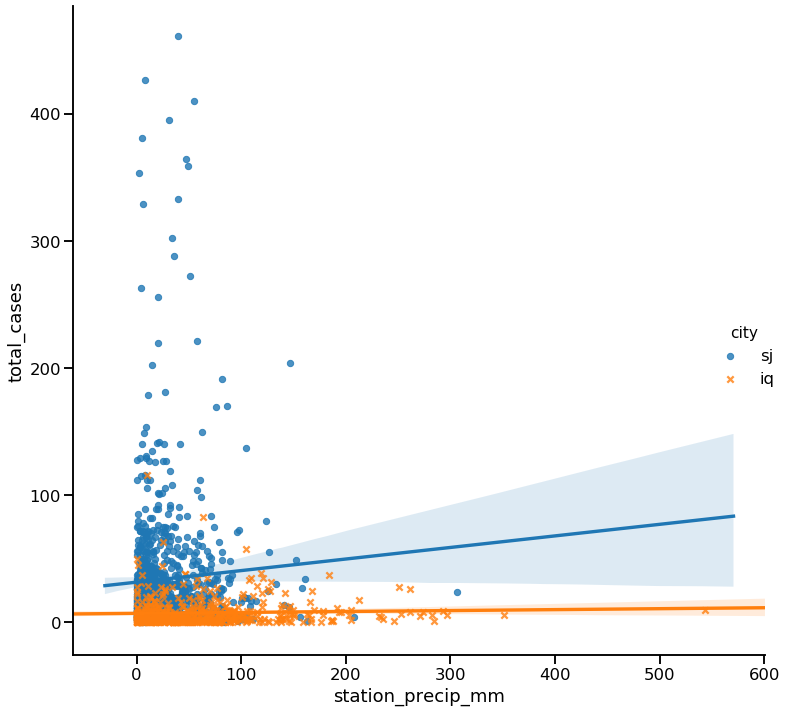

In [22]:
# Plotting of other variables with respect to total cases
for i, col in enumerate(numeric_cols):
    sns.lmplot(x=col, y="total_cases", hue='city', data=train, markers = ['o', 'x'], size = 10, scatter_kws={"s": 40})
    plt.tight_layout()